# Task: Goldfish-to-shark adversarial attack

You are given a set of images that are classified by a model trained on Imagenet as a goldfish (class `GOLDFISH_LABEL=1`).<br>
Your task is to compute a strip of pixels of height 10, which, when pasted into the top 10 rows of *each* of the original images, makes the model classify each image as a shark (class `SHARK_LABEL=2`) with returned probability at least 0.5.

This should run under 2 minutes on CPU.

## Data

Below you can find a piece of code that download a zipfile and displays the images.

In [195]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import zipfile
from io import BytesIO
from PIL import Image
from torch import Tensor
from torchvision.transforms import v2
from typing import cast

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD


torch.use_deterministic_algorithms(True)


def get_images(
    url: str = "https://www.mimuw.edu.pl/~cygan/goldfish.zip",
    target_height: int = 100,
    target_width: int = 100,
) -> list[Tensor]:
    """Return five images as tensors of shape (C=3, H=target_height, W=target_width), 0..1 values."""
    request = requests.get(url)
    images = []
    with zipfile.ZipFile(BytesIO(request.content)) as z:
        for filename in z.namelist():
            if not filename.lower().endswith((".jpg", ".jpeg")):
                continue
            with z.open(filename) as f:
                images.append(Image.open(f).convert("RGB"))

    transformations = v2.Compose([
        v2.Resize(size=(target_height, target_width)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),  # scale to 0..1
    ])
    return [cast(Tensor, transformations(img)) for img in images]


def tensor_to_pil(image: Tensor) -> PIL.Image.Image:
    """Convert image tensor of shape (C, H, W), values 0..1, to PIL Image."""
    C, H, W = image.shape
    image = image.detach().permute(1, 2, 0).clone()  # to (H, W, C)
    img = PIL.Image.fromarray((image.numpy() * 255).astype(np.uint8))
    return img


normalize_colors = v2.Normalize(
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD
)

torch.Size([3, 100, 100])


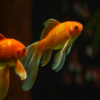

torch.Size([3, 100, 100])


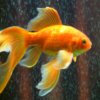

torch.Size([3, 100, 100])


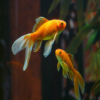

torch.Size([3, 100, 100])


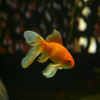

torch.Size([3, 100, 100])


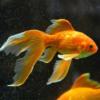

In [196]:
images = get_images()
for img in images:
    print(img.shape)
    display(tensor_to_pil(img))

## Model

We will be using the `mobilenet_v2` model, trained to do classification on the Imagenet dataset.
For this task, the model is a black-box: you do not have to know the details of the model's architecture.
In particular the model's weights should not be changed.

In [197]:
import torch.nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

DEFAULT_DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

def get_model(device: str = DEFAULT_DEVICE) -> torch.nn.Module:
    """Load a pretrained MobileNetV2 model.

    Input: normalized (not 0..1) images of shape (B, C, H, W),
    Output: logits (not probabilities or logprobs) of shape (B, num_classes=1000,).
    """
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    model.to(torch.device(device))
    model.eval()
    model.requires_grad_(False)
    return model

GOLDFISH_LABEL = MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"].index("goldfish")
SHARK_LABEL = MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"].index("great white shark")
GOLDFISH_LABEL, SHARK_LABEL

(1, 2)

In [198]:
model = get_model()
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Evaluation

Below is a piece of code for:
* pasting the strip and running model inference on a normalized image;
* evaluating how well a strip performs, for this attack task.

In [202]:
STRIP_HEIGHT = 5

def evaluate_strip(model: torch.nn.Module, images: list[Tensor], strip: Tensor, quiet = False) -> float:
    """
    Print goldfish and shark probabilities for each image with the given strip pasted on top.

    Args:
    - model: the classification model.
    - images: list of tensors of shape (3, H, W), values 0..1
    - strip: tensor of shape (3, STRIP_HEIGHT, W), values 0..1.
    """
    C, H, W = images[0].shape
    assert strip.shape == (C, STRIP_HEIGHT, W)
    assert strip.min() >= 0 and strip.max() <= 1, f"Strip should be 0..1, got {strip.min()=}, {strip.max()=}."

    device = next(model.parameters()).device
    p_shark_sum = 0
    min_p_shark = 1.0

    for img in images:
        img = img.clone().to(device)
        img[:, :strip.shape[1], :] = strip.to(device)
        img = normalize_colors(img)
        logits = model(img.unsqueeze(0)).squeeze(0)  # Shape (num_classes=1000,)
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        p_goldfish, p_shark = probabilities[[GOLDFISH_LABEL, SHARK_LABEL]]
        if not quiet:
          print(f'Probabilities assigned to: goldfish={p_goldfish:.5%}, shark={p_shark:.5%}.')
        p_shark_sum += p_shark.item()
        min_p_shark = min(min_p_shark, p_shark.item())

    return min_p_shark


zero_strip = torch.zeros(3, STRIP_HEIGHT, images[0].shape[2])
evaluate_strip(model, images, zero_strip)

Probabilities assigned to: goldfish=99.93781%, shark=0.00000%.
Probabilities assigned to: goldfish=99.99744%, shark=0.00000%.
Probabilities assigned to: goldfish=99.22845%, shark=0.00000%.
Probabilities assigned to: goldfish=95.38525%, shark=0.00000%.
Probabilities assigned to: goldfish=99.73612%, shark=0.00000%.


6.183001024151133e-14

## TO IMPLEMENT

Here you have to implement the function that finds the strip.


In [206]:


def calculate_strip(model, all_images, seed: int = 1, quiet: bool = False, strip : Tensor = None, alpha=0.02) -> Tensor:
    images_to_train = all_images
    device = next(model.parameters()).device
    torch.manual_seed(seed)

    C, H, W = all_images[0].shape
    B = len(all_images)

    if strip is None:
        strip = torch.rand(C, STRIP_HEIGHT, W, device=device, requires_grad=True)
    alpha = 0.02
    num_steps = 100000
    target = torch.full((B,), SHARK_LABEL, dtype=torch.long, device=device)

    for step in range(num_steps):
        batch = []
        for img in images_to_train:
            img2 = img.clone().to(device)
            img2[:, :STRIP_HEIGHT, :] = strip
            batch.append(img2)
        batch = torch.stack(batch)
        batch_norm = normalize_colors(batch)

        logits = model(batch_norm)

        target_logits = logits[:, SHARK_LABEL]
        
        logits_others = logits.clone()
        logits_others[:, SHARK_LABEL] = -1e9
        max_other_logits = logits_others.max(dim=1)[0]
        
        loss = (max_other_logits - target_logits).mean()

        if strip.grad is not None:
            strip.grad.zero_()
        loss.backward()

        with torch.no_grad():
            grad_sign = strip.grad.sign()
            strip -= alpha * grad_sign
            strip.clamp_(0.0, 1.0)
        
        batch = []
        for img in all_images:
            img2 = img.clone().to(device)
            img2[:, :STRIP_HEIGHT, :] = strip
            batch.append(img2)
        batch = torch.stack(batch)
        batch_norm = normalize_colors(batch)

        images_to_train = []
        with torch.no_grad():
            logits = model(batch_norm)
            probs = torch.nn.functional.softmax(logits, dim=-1)
            p_shark = probs[:, SHARK_LABEL]

            for i, p in enumerate(p_shark):
                if p < 0.5:
                    images_to_train.append(all_images[i])
            
            missing = B - len(images_to_train)
            if missing > 0:
                i = torch.argmin(p_shark).item()
                for _ in range(missing):
                    images_to_train.append(all_images[i])


            if not quiet and (step % 200 == 0 or step == num_steps-1):
                print(f"step {step}, loss {loss.item():.4f}, min p_shark {p_shark.min().item():.4f}, mean {p_shark.mean().item():.4f}, ammount_below_0.5={len(set(images_to_train))}")
                if (p_shark >= 0.5).all():
                    print("Warunek osiągnięty, przerywam.")
                    break

    return strip.detach().cpu()
device = next(model.parameters()).device
your_strips = []
next_strip = None

for i, img in enumerate(images):
    print(f"Calculating strip for image {i+1}/5")
    your_strip = calculate_strip(model, [img for _ in range(5)], quiet=False, strip=next_strip)
    your_strips.append(your_strip)
    next_strip = your_strip.to(device).detach().clone().requires_grad_(True)



avg_strip = torch.stack(your_strips).mean(dim=0)
avg_strip = avg_strip.to(device).detach().clone().requires_grad_(True)

your_strip = calculate_strip(model, [images[0], images[1], images[2], images[3], images[3]], quiet=False, strip=avg_strip, alpha=0.003)

Calculating strip for image 1/5
step 0, loss 23.1988, min p_shark 0.0000, mean 0.0000, ammount_below_0.5=1
step 200, loss 0.7691, min p_shark 0.0183, mean 0.0183, ammount_below_0.5=1
step 200, loss 0.7691, min p_shark 0.0183, mean 0.0183, ammount_below_0.5=1
step 400, loss -4.8475, min p_shark 0.9240, mean 0.9240, ammount_below_0.5=1
Warunek osiągnięty, przerywam.
Calculating strip for image 2/5
step 0, loss 21.8686, min p_shark 0.0000, mean 0.0000, ammount_below_0.5=1
step 400, loss -4.8475, min p_shark 0.9240, mean 0.9240, ammount_below_0.5=1
Warunek osiągnięty, przerywam.
Calculating strip for image 2/5
step 0, loss 21.8686, min p_shark 0.0000, mean 0.0000, ammount_below_0.5=1
step 200, loss 4.5032, min p_shark 0.0011, mean 0.0011, ammount_below_0.5=1
step 200, loss 4.5032, min p_shark 0.0011, mean 0.0011, ammount_below_0.5=1
step 400, loss 2.5987, min p_shark 0.0086, mean 0.0086, ammount_below_0.5=1
step 400, loss 2.5987, min p_shark 0.0086, mean 0.0086, ammount_below_0.5=1
step 60

# Linear Combinations of Strips

Probabilities assigned to: goldfish=0.80957%, shark=58.26280%.
Probabilities assigned to: goldfish=3.96394%, shark=54.07006%.
Probabilities assigned to: goldfish=1.35784%, shark=54.53753%.
Probabilities assigned to: goldfish=0.15577%, shark=53.97609%.
Probabilities assigned to: goldfish=1.31300%, shark=0.00090%.


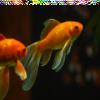

In [207]:
from torchvision.transforms.functional import to_pil_image



evaluate_strip(model, images, your_strip)

img_pil   = to_pil_image(images[0])
strip_pil = to_pil_image(your_strip)  # Tensor 3xHstripxW

img_pil.paste(strip_pil, (0, 0))  # wkleja pasek u góry
display(img_pil)

strip_pil.save("strip.jpg", format="JPEG")
